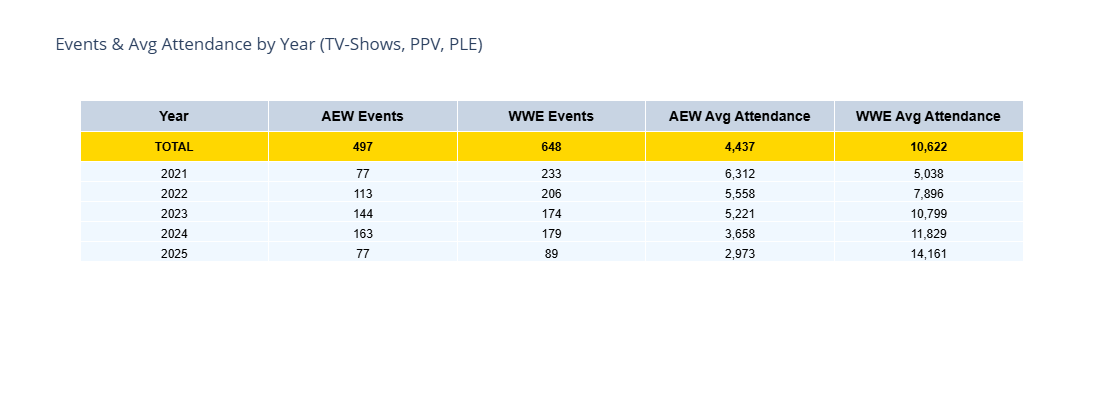

<Figure size 640x480 with 0 Axes>

In [65]:
import pandas as pd
import plotly.graph_objects as go

# 1. Load your data
df = pd.read_csv('report_pro_wrestling_events.csv')

# 2. Convert calendar_date to datetime (if not already)
df['calendar_date'] = pd.to_datetime(df['calendar_date'])

# 3. Filter for 2021 and later
df = df[df['calendar_date'].dt.year >= 2021]

# 4. Filter for specific event types
desired_types = ['TV-Show', 'Pay Per View', 'Premium Live Event']
df = df[df['event_type'].isin(desired_types)]

# 5. Add calendar_year column
df['calendar_year'] = df['calendar_date'].dt.year

# 6. Group by year and brand, count events and calculate average attendance
summary = df.groupby(['calendar_year', 'brand']).agg(
    events=('event_name', 'count'),
    avg_attendance=('attendance', 'mean')
).reset_index()

# 7. Pivot to get WWE and AEW as separate columns
summary_pivot = summary.pivot(index='calendar_year', columns='brand', values=['events', 'avg_attendance'])

# 8. Flatten MultiIndex columns for readability
summary_pivot.columns = [f"{stat}_{brand}".lower() for stat, brand in summary_pivot.columns]
summary_pivot = summary_pivot.reset_index()

# 9. Format avg_attendance and events columns as full numbers with commas
for col in summary_pivot.columns:
    if col.startswith('avg_attendance'):
        summary_pivot[col] = pd.to_numeric(summary_pivot[col], errors='coerce').round(0).astype('Int64').map('{:,}'.format)
for col in summary_pivot.columns:
    if col.startswith('events'):
        summary_pivot[col] = pd.to_numeric(summary_pivot[col], errors='coerce').astype('Int64').map('{:,}'.format)

# 10. Prepare the total row (with formatted values)
total_row = {'calendar_year': 'TOTAL'}
for col in summary_pivot.columns:
    if col == 'calendar_year':
        continue
    if col.startswith('events'):
        total_row[col] = '{:,}'.format(
            int(pd.to_numeric(summary_pivot.loc[1:, col].replace({',': ''}, regex=True), errors='coerce').sum())
        )
    elif col.startswith('avg_attendance'):
        events_col = col.replace('avg_attendance', 'events')
        total_events = pd.to_numeric(summary_pivot.loc[1:, events_col].replace({',': ''}, regex=True), errors='coerce').sum()
        avg_att = pd.to_numeric(summary_pivot.loc[1:, col].replace({',': ''}, regex=True), errors='coerce').fillna(0)
        events = pd.to_numeric(summary_pivot.loc[1:, events_col].replace({',': ''}, regex=True), errors='coerce').fillna(0)
        total_attendance = (events * avg_att).sum()
        weighted_avg = total_attendance / total_events if total_events > 0 else 0
        total_row[col] = '{:,}'.format(int(round(weighted_avg)))
    else:
        total_row[col] = ''

# 11. Insert the total row at the top
summary_pivot = pd.concat([pd.DataFrame([total_row]), summary_pivot], ignore_index=True)

# 12. Remove any columns containing % change (if any exist)
summary_pivot = summary_pivot.loc[:, ~summary_pivot.columns.str.contains('_pct_change')]  # [1][5]

# 13. Rename columns for display
header_rename = {
    'calendar_year': 'Year',
    'events_aew': 'AEW Events',
    'events_wwe': 'WWE Events',
    'avg_attendance_aew': 'AEW Avg Attendance',
    'avg_attendance_wwe': 'WWE Avg Attendance'
}
summary_pivot = summary_pivot.rename(columns=header_rename)

# 14. Bold the total row using HTML <b>...</b> tags
for col in summary_pivot.columns:
    summary_pivot.loc[0, col] = f"<b>{summary_pivot.loc[0, col]}</b>"

# 15. Prepare cell colors: gold for total row, lavender for others
n_rows = summary_pivot.shape[0]
n_cols = summary_pivot.shape[1]
cell_colors = []
for col in range(n_cols):
    col_colors = ['gold'] + ['aliceblue'] * (n_rows - 1)
    cell_colors.append(col_colors)

# 16. Display as a visual table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(
        values=[f"<b>{col}</b>" for col in summary_pivot.columns],
        fill_color='light grey',
        align='center',
        font=dict(size=14, color='black', family='Arial')
    ),
    cells=dict(
        values=[summary_pivot[col] for col in summary_pivot.columns],
        fill_color=cell_colors,
        align='center',
        font=dict(size=12, family='Arial', color='black')
    )
)])

fig.update_layout(
    title="Events & Avg Attendance by Year (TV-Shows, PPV, PLE)",
    width=900,
    height=400
)
plt.tight_layout()
plt.savefig('table_summary_by_year.png', dpi=300, bbox_inches='tight')  # Save before plt.show()
fig.show()


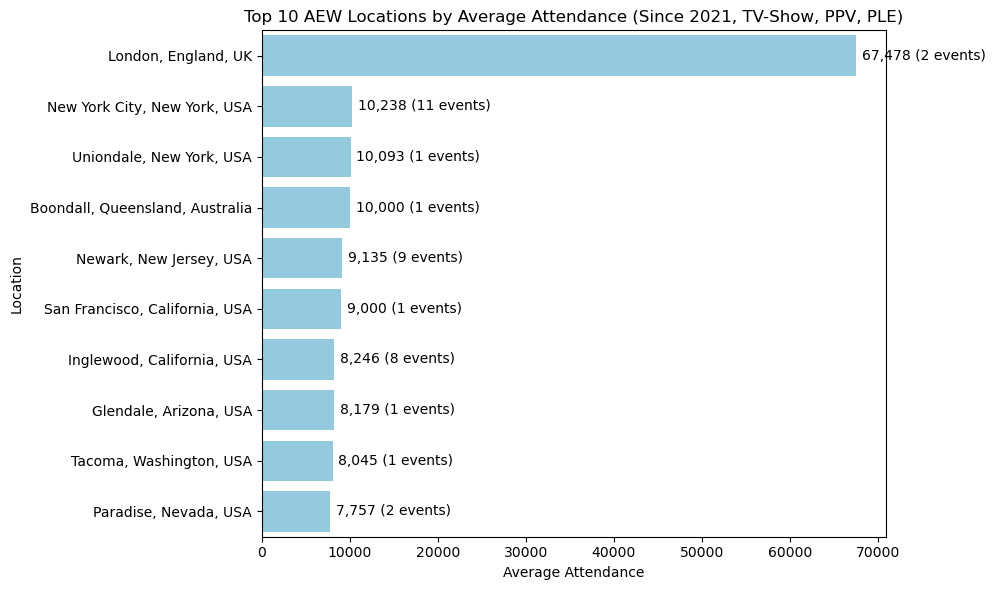

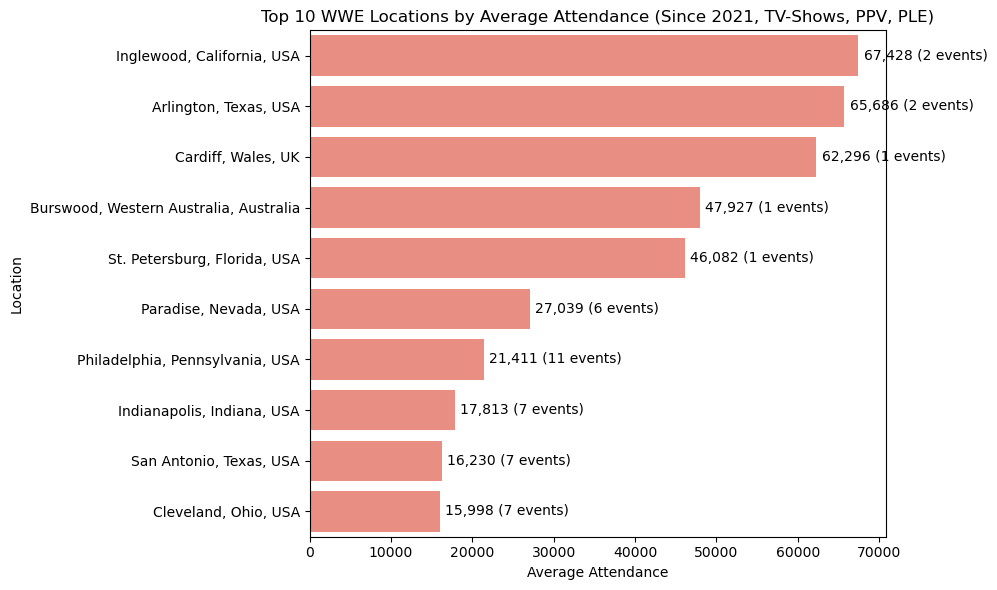

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv('report_pro_wrestling_events.csv')

# Convert calendar_date to datetime if not already
df['calendar_date'] = pd.to_datetime(df['calendar_date'])

# Apply both filters at once
desired_types = ['TV-Show', 'Pay Per View', 'Premium Live Event']
df = df[
    (df['calendar_date'].dt.year >= 2021) &
    (df['event_type'].isin(desired_types))
]

# Create a combined location column: city, state, country
df['location'] = df['city'].astype(str) + ', ' + df['state'].astype(str) + ', ' + df['country'].astype(str)

# Filter for AEW and WWE
aew_df = df[df['brand'] == 'AEW']
wwe_df = df[df['brand'] == 'WWE']

# Group by location: calculate average attendance and event count
aew_loc_stats = aew_df.groupby('location').agg(
    avg_attendance=('attendance', 'mean'),
    events=('attendance', 'count')
).sort_values('avg_attendance', ascending=False).head(10)

wwe_loc_stats = wwe_df.groupby('location').agg(
    avg_attendance=('attendance', 'mean'),
    events=('attendance', 'count')
).sort_values('avg_attendance', ascending=False).head(10)

# --- AEW Visual ---
plt.figure(figsize=(10,6))
ax = sns.barplot(
    x=aew_loc_stats['avg_attendance'], 
    y=aew_loc_stats.index, 
    color='skyblue'
)
plt.title('Top 10 AEW Locations by Average Attendance (Since 2021, TV-Show, PPV, PLE)')
plt.xlabel('Average Attendance')
plt.ylabel('Location')

for i, (avg, n) in enumerate(zip(aew_loc_stats['avg_attendance'], aew_loc_stats['events'])):
    ax.text(
        avg + max(aew_loc_stats['avg_attendance']) * 0.01,
        i, 
        f"{int(round(avg)):,} ({n} events)", 
        va='center', 
        fontsize=10, 
        color='black'
    )

# Save the figure as a PNG file
plt.savefig('aew_avg_attendance_by_location.png', dpi=300, bbox_inches='tight')  # Save before plt.show()
plt.tight_layout()
plt.show()

# --- WWE Visual ---
plt.figure(figsize=(10,6))
ax = sns.barplot(
    x=wwe_loc_stats['avg_attendance'], 
    y=wwe_loc_stats.index, 
    color='salmon'
)
plt.title('Top 10 WWE Locations by Average Attendance (Since 2021, TV-Shows, PPV, PLE)')
plt.xlabel('Average Attendance')
plt.ylabel('Location')

for i, (avg, n) in enumerate(zip(wwe_loc_stats['avg_attendance'], wwe_loc_stats['events'])):
    ax.text(
        avg + max(wwe_loc_stats['avg_attendance']) * 0.01,
        i, 
        f"{int(round(avg)):,} ({n} events)", 
        va='center', 
        fontsize=10, 
        color='black'
    )

# Save the figure as a PNG file
plt.savefig('wwe_avg_attendance_by_location.png', dpi=300, bbox_inches='tight')  # Save before plt.show()
plt.tight_layout()
plt.show()


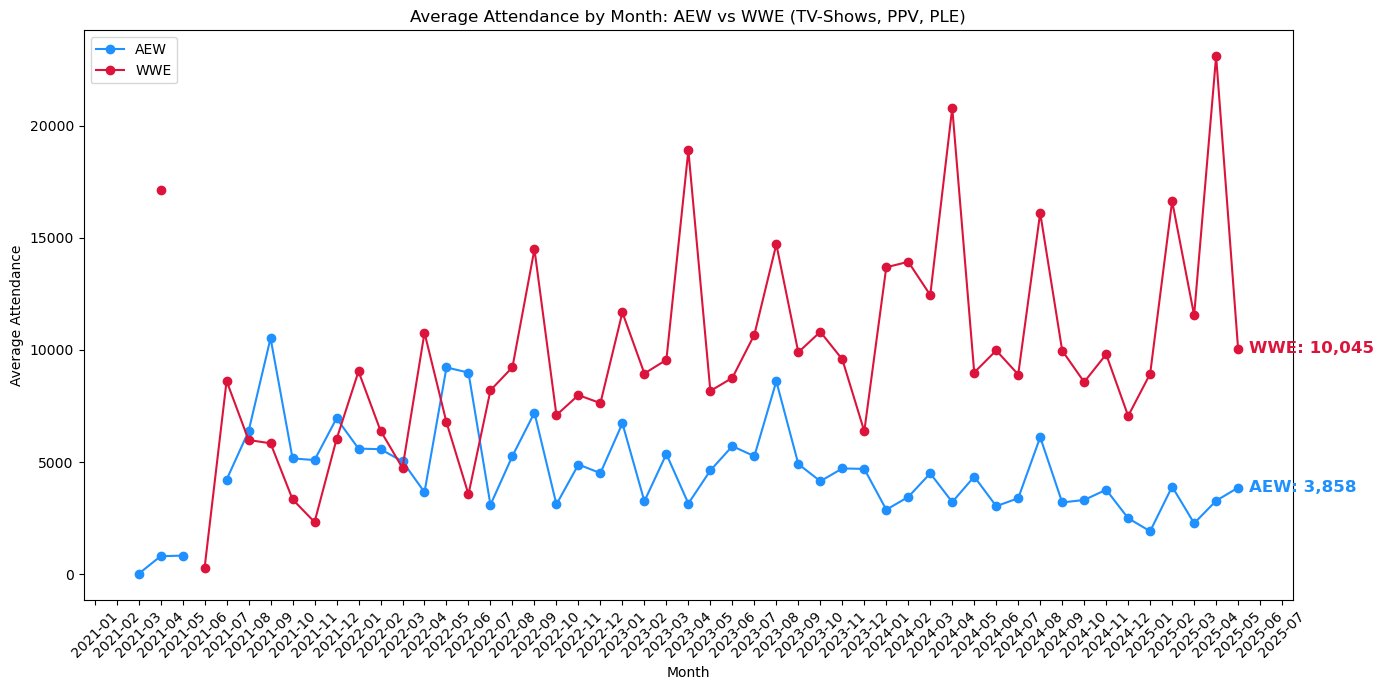

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('report_pro_wrestling_events.csv')

# Convert calendar_date to datetime if not already
df['calendar_date'] = pd.to_datetime(df['calendar_date'])

# Apply both filters at once (multiple conditions)
desired_types = ['TV-Show', 'Pay Per View', 'Premium Live Event']
df = df[
    (df['calendar_date'].dt.year >= 2021) &
    (df['event_type'].isin(desired_types))
]

# Continue with your grouping and pivoting logic
df['year_month'] = df['calendar_date'].dt.to_period('M')
monthly_avg = df.groupby(['year_month', 'brand'])['attendance'].mean().reset_index()
pivot = monthly_avg.pivot(index='year_month', columns='brand', values='attendance')

fig, ax = plt.subplots(figsize=(14,7))
for brand, color in zip(['AEW', 'WWE'], ['dodgerblue', 'crimson']):
    if brand in pivot.columns:
        x = pivot.index.astype(str)
        y = pivot[brand]
        ax.plot(x, y, marker='o', label=brand, color=color)
        # Find the last non-NaN point
        last_valid_idx = y.last_valid_index()
        if last_valid_idx is not None:
            last_x = str(last_valid_idx)
            last_y = y.loc[last_valid_idx]
            ax.annotate(
                f"{brand}: {int(round(last_y)):,}",
                xy=(last_x, last_y),
                xytext=(8, 0),
                textcoords='offset points',
                color=color,
                fontsize=12,
                fontweight='bold',
                va='center'
            )

ax.set_title('Average Attendance by Month: AEW vs WWE (TV-Shows, PPV, PLE)')
ax.set_xlabel('Month')
ax.set_ylabel('Average Attendance')
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.savefig('avg_attendance_over_time.png', dpi=300, bbox_inches='tight')  # Save before plt.show()
plt.show()


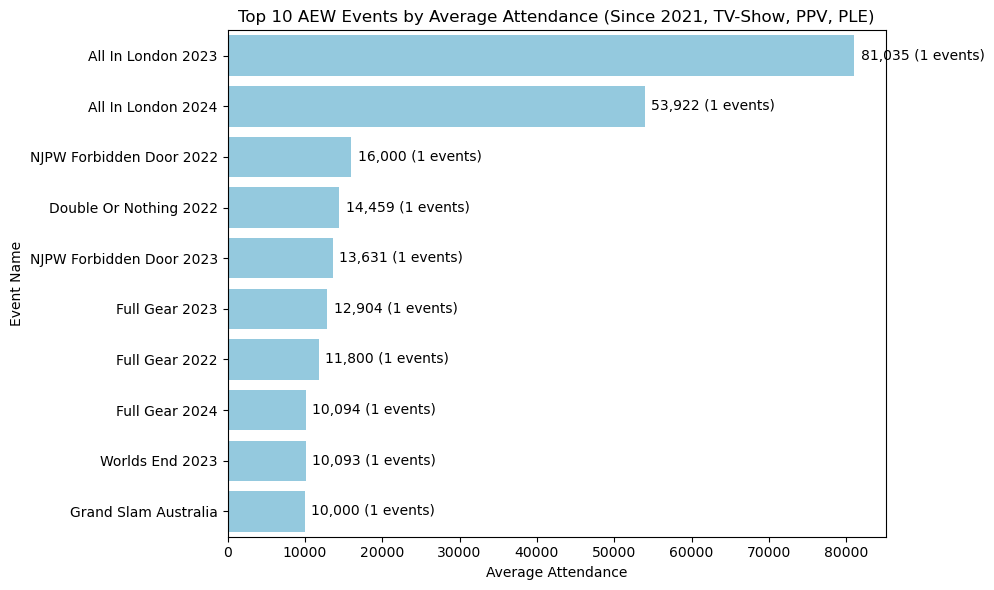

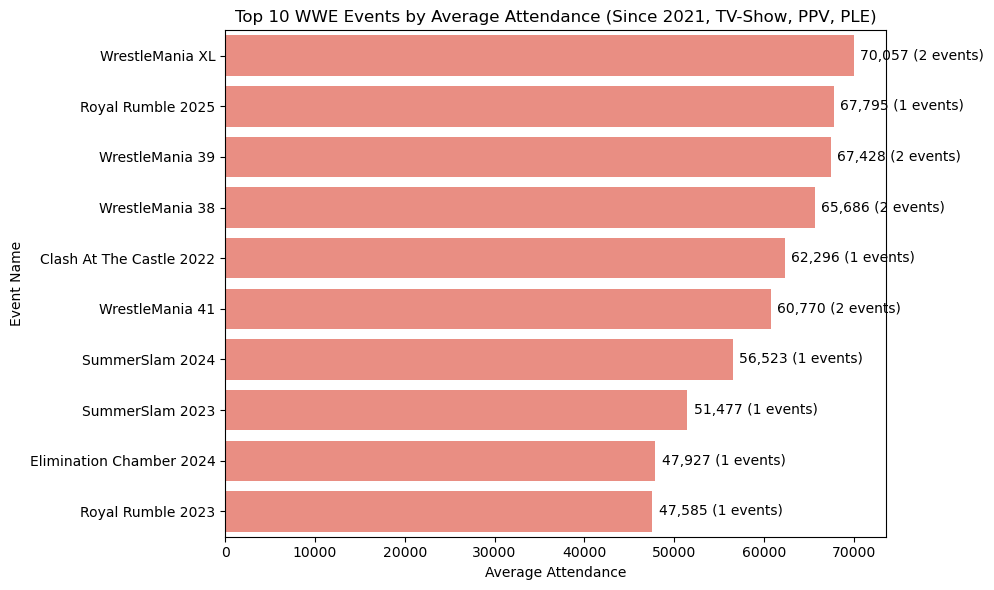

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv('report_pro_wrestling_events.csv')

# Convert calendar_date to datetime if not already
df['calendar_date'] = pd.to_datetime(df['calendar_date'])

# Apply both filters at once
desired_types = ['TV-Show', 'Pay Per View', 'Premium Live Event']
df = df[
    (df['calendar_date'].dt.year >= 2021) &
    (df['event_type'].isin(desired_types))
]

# Filter for AEW and WWE
aew_df = df[df['brand'] == 'AEW']
wwe_df = df[df['brand'] == 'WWE']

# Group by event_name: calculate average attendance and event count
aew_event_stats = aew_df.groupby('event_name').agg(
    avg_attendance=('attendance', 'mean'),
    events=('attendance', 'count')
).sort_values('avg_attendance', ascending=False).head(10)

wwe_event_stats = wwe_df.groupby('event_name').agg(
    avg_attendance=('attendance', 'mean'),
    events=('attendance', 'count')
).sort_values('avg_attendance', ascending=False).head(10)

# --- AEW Visual ---
plt.figure(figsize=(10,6))
ax = sns.barplot(
    x=aew_event_stats['avg_attendance'], 
    y=aew_event_stats.index, 
    color='skyblue'
)
plt.title('Top 10 AEW Events by Average Attendance (Since 2021, TV-Show, PPV, PLE)')
plt.xlabel('Average Attendance')
plt.ylabel('Event Name')

for i, (avg, n) in enumerate(zip(aew_event_stats['avg_attendance'], aew_event_stats['events'])):
    ax.text(
        avg + max(aew_event_stats['avg_attendance']) * 0.01,
        i, 
        f"{int(round(avg)):,} ({n} events)", 
        va='center', 
        fontsize=10, 
        color='black'
    )

plt.savefig('aew_avg_attendance_by_event.png', dpi=300, bbox_inches='tight')  # Save before plt.show()
plt.tight_layout()
plt.show()

# --- WWE Visual ---
plt.figure(figsize=(10,6))
ax = sns.barplot(
    x=wwe_event_stats['avg_attendance'], 
    y=wwe_event_stats.index, 
    color='salmon'
)
plt.title('Top 10 WWE Events by Average Attendance (Since 2021, TV-Show, PPV, PLE)')
plt.xlabel('Average Attendance')
plt.ylabel('Event Name')

for i, (avg, n) in enumerate(zip(wwe_event_stats['avg_attendance'], wwe_event_stats['events'])):
    ax.text(
        avg + max(wwe_event_stats['avg_attendance']) * 0.01,
        i, 
        f"{int(round(avg)):,} ({n} events)", 
        va='center', 
        fontsize=10, 
        color='black'
    )

plt.savefig('wwe_avg_attendance_by_event.png', dpi=300, bbox_inches='tight')  # Save before plt.show()
plt.tight_layout()
plt.show()


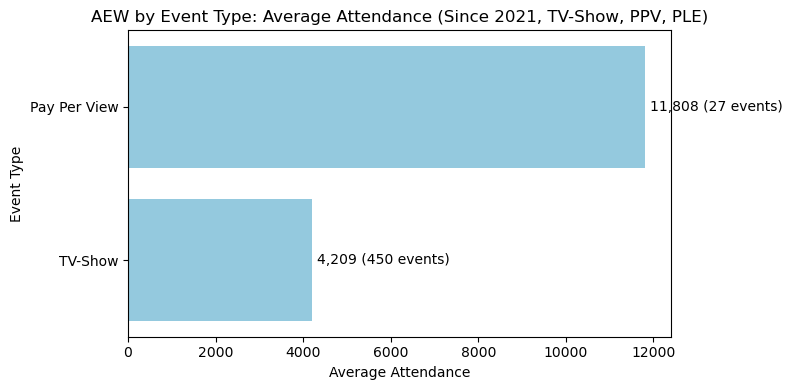

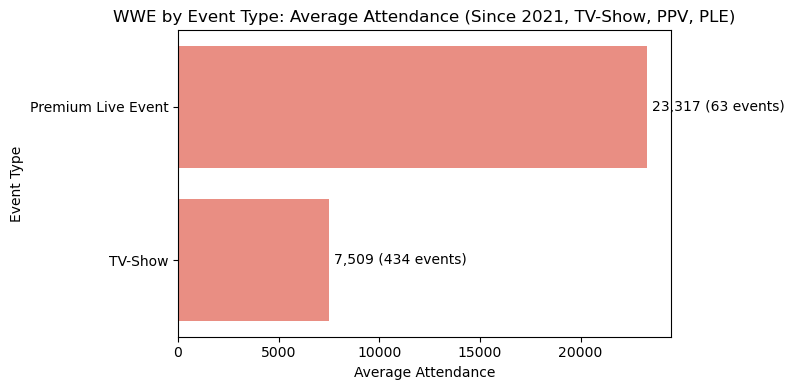

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv('report_pro_wrestling_events.csv')

# Convert calendar_date to datetime if not already
df['calendar_date'] = pd.to_datetime(df['calendar_date'])

# Apply both filters at once
desired_types = ['TV-Show', 'Pay Per View', 'Premium Live Event']
df = df[
    (df['calendar_date'].dt.year >= 2021) &
    (df['event_type'].isin(desired_types))
]

# Filter for AEW and WWE
aew_df = df[df['brand'] == 'AEW']
wwe_df = df[df['brand'] == 'WWE']

# Group by event_type: calculate average attendance and event count
aew_type_stats = aew_df.groupby('event_type').agg(
    avg_attendance=('attendance', 'mean'),
    events=('attendance', 'count')
).sort_values('avg_attendance', ascending=False)

wwe_type_stats = wwe_df.groupby('event_type').agg(
    avg_attendance=('attendance', 'mean'),
    events=('attendance', 'count')
).sort_values('avg_attendance', ascending=False)

# --- AEW Visual ---
plt.figure(figsize=(8,4))
ax = sns.barplot(
    x=aew_type_stats['avg_attendance'], 
    y=aew_type_stats.index, 
    color='skyblue'
)
plt.title('AEW by Event Type: Average Attendance (Since 2021, TV-Show, PPV, PLE)')
plt.xlabel('Average Attendance')
plt.ylabel('Event Type')

for i, (avg, n) in enumerate(zip(aew_type_stats['avg_attendance'], aew_type_stats['events'])):
    ax.text(
        avg + max(aew_type_stats['avg_attendance']) * 0.01,
        i, 
        f"{int(round(avg)):,} ({n} events)", 
        va='center', 
        fontsize=10, 
        color='black'
    )

plt.savefig('aew_avg_attendance_by_broadcast.png', dpi=300, bbox_inches='tight')  # Save before plt.show()
plt.tight_layout()
plt.show()

# --- WWE Visual ---
plt.figure(figsize=(8,4))
ax = sns.barplot(
    x=wwe_type_stats['avg_attendance'], 
    y=wwe_type_stats.index, 
    color='salmon'
)
plt.title('WWE by Event Type: Average Attendance (Since 2021, TV-Show, PPV, PLE)')
plt.xlabel('Average Attendance')
plt.ylabel('Event Type')

for i, (avg, n) in enumerate(zip(wwe_type_stats['avg_attendance'], wwe_type_stats['events'])):
    ax.text(
        avg + max(wwe_type_stats['avg_attendance']) * 0.01,
        i, 
        f"{int(round(avg)):,} ({n} events)", 
        va='center', 
        fontsize=10, 
        color='black'
    )

plt.savefig('wwe_avg_attendance_by_broadcast.png', dpi=300, bbox_inches='tight')  # Save before plt.show()
plt.tight_layout()
plt.show()


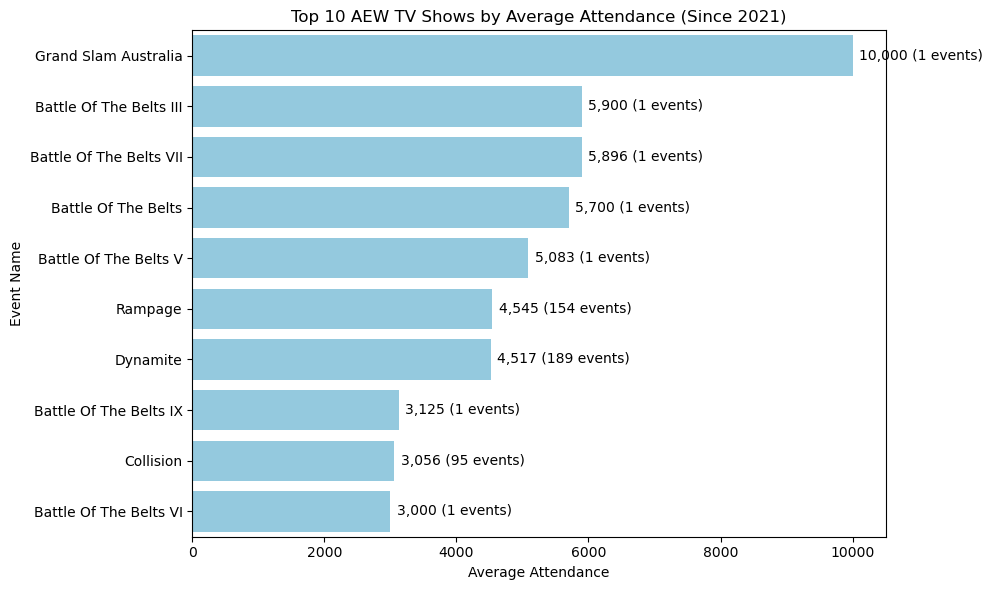

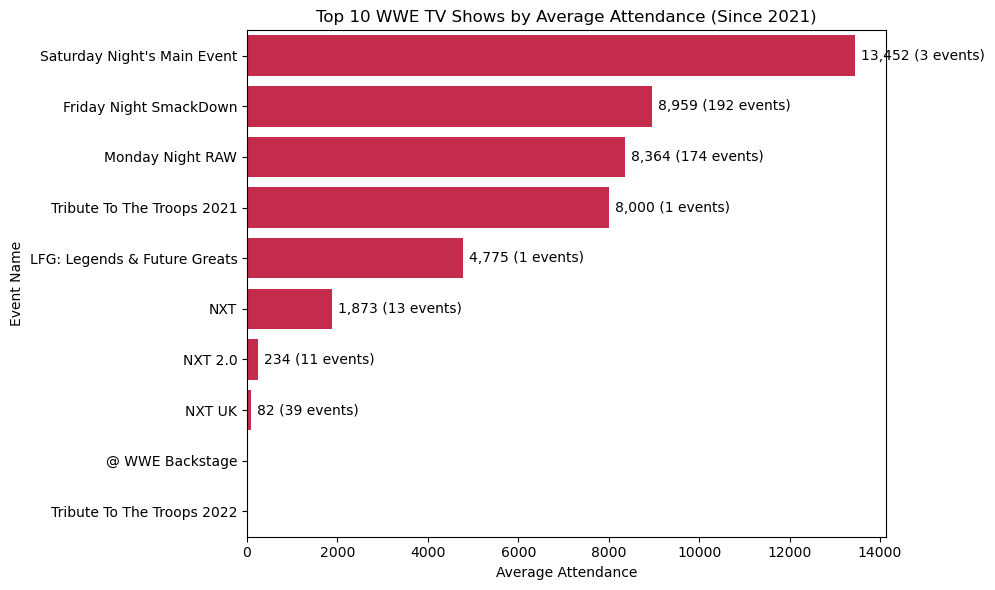

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv('report_pro_wrestling_events.csv')

# Convert calendar_date to datetime if not already
df['calendar_date'] = pd.to_datetime(df['calendar_date'])

# Apply filters: 2021+, only TV-Show events
df = df[
    (df['calendar_date'].dt.year >= 2021) &
    (df['event_type'] == 'TV-Show')
]

# Filter for AEW and WWE
aew_df = df[df['brand'] == 'AEW']
wwe_df = df[df['brand'] == 'WWE']

# Group by event_name: calculate average attendance and event count
aew_event_stats = aew_df.groupby('event_name').agg(
    avg_attendance=('attendance', 'mean'),
    events=('attendance', 'count')
).sort_values('avg_attendance', ascending=False).head(10)

wwe_event_stats = wwe_df.groupby('event_name').agg(
    avg_attendance=('attendance', 'mean'),
    events=('attendance', 'count')
).sort_values('avg_attendance', ascending=False).head(10)

# --- AEW Visual ---
plt.figure(figsize=(10,6))
ax = sns.barplot(
    x=aew_event_stats['avg_attendance'], 
    y=aew_event_stats.index, 
    color='skyblue'
)
plt.title('Top 10 AEW TV Shows by Average Attendance (Since 2021)')
plt.xlabel('Average Attendance')
plt.ylabel('Event Name')

for i, (avg, n) in enumerate(zip(aew_event_stats['avg_attendance'], aew_event_stats['events'])):
    if pd.notnull(avg):  # Only annotate if not NaN
        ax.text(
            avg + max(aew_event_stats['avg_attendance']) * 0.01,
            i, 
            f"{int(round(avg)):,} ({n} events)", 
            va='center', 
            fontsize=10, 
            color='black'
        )

plt.tight_layout()
plt.show()

# --- WWE Visual ---
plt.figure(figsize=(10,6))
ax = sns.barplot(
    x=wwe_event_stats['avg_attendance'], 
    y=wwe_event_stats.index, 
    color='crimson'
)
plt.title('Top 10 WWE TV Shows by Average Attendance (Since 2021)')
plt.xlabel('Average Attendance')
plt.ylabel('Event Name')

for i, (avg, n) in enumerate(zip(wwe_event_stats['avg_attendance'], wwe_event_stats['events'])):
    if pd.notnull(avg):  # Only annotate if not NaN
        ax.text(
            avg + max(wwe_event_stats['avg_attendance']) * 0.01,
            i, 
            f"{int(round(avg)):,} ({n} events)", 
            va='center', 
            fontsize=10, 
            color='black'
        )

plt.tight_layout()
plt.show()


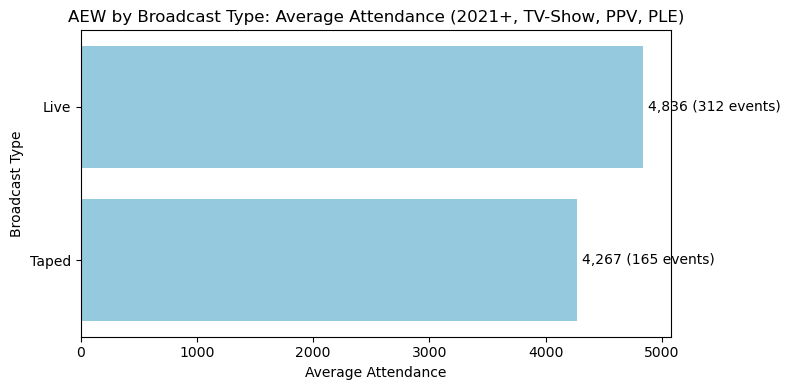

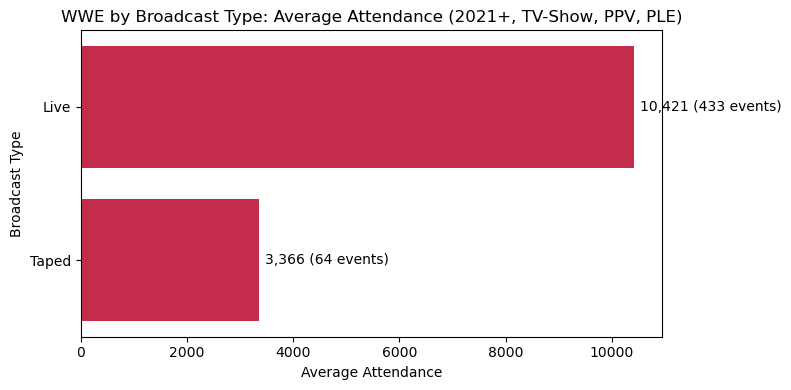

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv('report_pro_wrestling_events.csv')

# Convert calendar_date to datetime if not already
df['calendar_date'] = pd.to_datetime(df['calendar_date'])

# Apply filters: 2021+, desired event types
desired_types = ['TV-Show', 'Pay Per View', 'Premium Live Event']
df = df[
    (df['calendar_date'].dt.year >= 2021) &
    (df['event_type'].isin(desired_types))
]

# Filter for AEW and WWE
aew_df = df[df['brand'] == 'AEW']
wwe_df = df[df['brand'] == 'WWE']

# --- By broadcast_type ---
aew_type_stats = aew_df.groupby('broadcast_type', observed=True).agg(
    avg_attendance=('attendance', 'mean'),
    events=('attendance', 'count')
).sort_values('avg_attendance', ascending=False)

wwe_type_stats = wwe_df.groupby('broadcast_type', observed=True).agg(
    avg_attendance=('attendance', 'mean'),
    events=('attendance', 'count')
).sort_values('avg_attendance', ascending=False)

plt.figure(figsize=(8,4))
ax = sns.barplot(
    x=aew_type_stats['avg_attendance'],
    y=aew_type_stats.index,
    color='skyblue'
)
plt.title('AEW by Broadcast Type: Average Attendance (2021+, TV-Show, PPV, PLE)')
plt.xlabel('Average Attendance')
plt.ylabel('Broadcast Type')
for i, (avg, n) in enumerate(zip(aew_type_stats['avg_attendance'], aew_type_stats['events'])):
    if pd.notnull(avg):
        ax.text(
            avg + max(aew_type_stats['avg_attendance']) * 0.01,
            i,
            f"{int(round(avg)):,} ({n} events)",
            va='center',
            fontsize=10,
            color='black'
        )
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
ax = sns.barplot(
    x=wwe_type_stats['avg_attendance'],
    y=wwe_type_stats.index,
    color='crimson'
)
plt.title('WWE by Broadcast Type: Average Attendance (2021+, TV-Show, PPV, PLE)')
plt.xlabel('Average Attendance')
plt.ylabel('Broadcast Type')
for i, (avg, n) in enumerate(zip(wwe_type_stats['avg_attendance'], wwe_type_stats['events'])):
    if pd.notnull(avg):
        ax.text(
            avg + max(wwe_type_stats['avg_attendance']) * 0.01,
            i,
            f"{int(round(avg)):,} ({n} events)",
            va='center',
            fontsize=10,
            color='black'
        )
plt.tight_layout()
plt.show()

# --- By


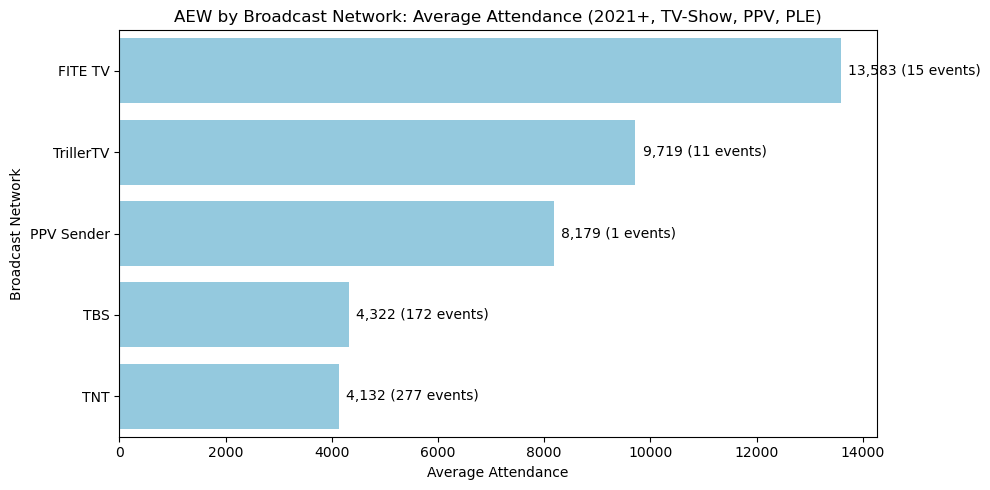

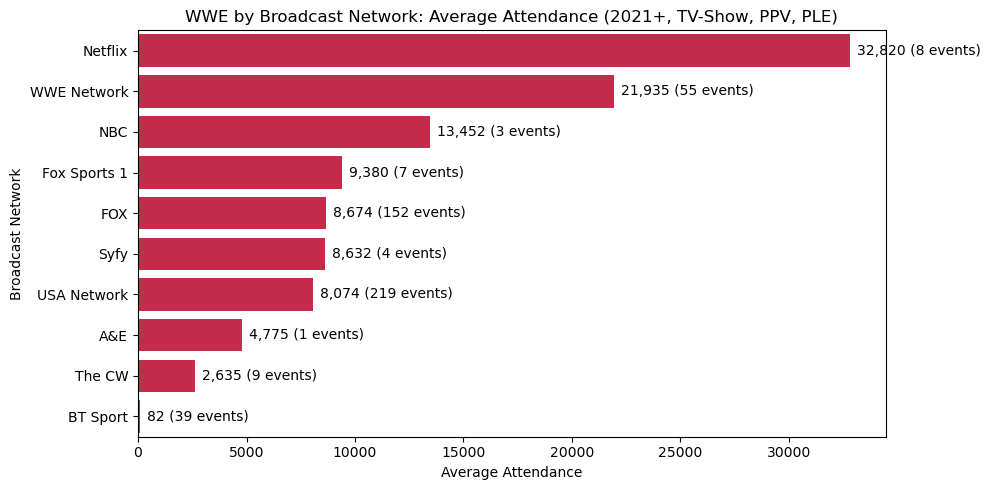

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv('report_pro_wrestling_events.csv')

# Convert calendar_date to datetime if not already
df['calendar_date'] = pd.to_datetime(df['calendar_date'])

# Apply filters: 2021+, desired event types
desired_types = ['TV-Show', 'Pay Per View', 'Premium Live Event']
df = df[
    (df['calendar_date'].dt.year >= 2021) &
    (df['event_type'].isin(desired_types))
]

# Filter for AEW and WWE
aew_df = df[df['brand'] == 'AEW']
wwe_df = df[df['brand'] == 'WWE']

# Group by broadcast_network: calculate average attendance and event count
aew_network_stats = aew_df.groupby('broadcast_network', observed=True).agg(
    avg_attendance=('attendance', 'mean'),
    events=('attendance', 'count')
).sort_values('avg_attendance', ascending=False)

wwe_network_stats = wwe_df.groupby('broadcast_network', observed=True).agg(
    avg_attendance=('attendance', 'mean'),
    events=('attendance', 'count')
).sort_values('avg_attendance', ascending=False)

# --- AEW Visual ---
plt.figure(figsize=(10,5))
ax = sns.barplot(
    x=aew_network_stats['avg_attendance'],
    y=aew_network_stats.index,
    color='skyblue'
)
plt.title('AEW by Broadcast Network: Average Attendance (2021+, TV-Show, PPV, PLE)')
plt.xlabel('Average Attendance')
plt.ylabel('Broadcast Network')
for i, (avg, n) in enumerate(zip(aew_network_stats['avg_attendance'], aew_network_stats['events'])):
    if pd.notnull(avg):
        ax.text(
            avg + max(aew_network_stats['avg_attendance']) * 0.01,
            i,
            f"{int(round(avg)):,} ({n} events)",
            va='center',
            fontsize=10,
            color='black'
        )
plt.tight_layout()
plt.savefig('aew_avg_attendance_by_network.png', dpi=300, bbox_inches='tight')  # Save before plt.show()
plt.show()

# --- WWE Visual ---
plt.figure(figsize=(10,5))
ax = sns.barplot(
    x=wwe_network_stats['avg_attendance'],
    y=wwe_network_stats.index,
    color='crimson'
)
plt.title('WWE by Broadcast Network: Average Attendance (2021+, TV-Show, PPV, PLE)')
plt.xlabel('Average Attendance')
plt.ylabel('Broadcast Network')
for i, (avg, n) in enumerate(zip(wwe_network_stats['avg_attendance'], wwe_network_stats['events'])):
    if pd.notnull(avg):
        ax.text(
            avg + max(wwe_network_stats['avg_attendance']) * 0.01,
            i,
            f"{int(round(avg)):,} ({n} events)",
            va='center',
            fontsize=10,
            color='black'
        )
plt.tight_layout()
plt.savefig('wwe_avg_attendance_by_network.png', dpi=300, bbox_inches='tight')  # Save before plt.show()
plt.show()
